In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
from utils_response import create_df_response
import pandas as pd
import datetime


In [3]:
# https://github.com/google/jax/issues/10144
def transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.minimum(np.maximum(x, 0), pop)

def f(x, dt, β, γ, N):
    """
    Process model
    """
    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()

    s2i = transition(S, β * I / N, dt)
    i2r = transition(I, γ, dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return checkpopvars(np.array([S, I, R, C]), N)

def g(x):
    """
    Observational model.
    """
    return x.at[3, :].get()

def f0(pop=1e-6, inf_init=1/100, m =300):
    """
    Initial guess of the state space.
    """

    I0 = pop * 0.01
    S0 = pop - inf_init
    R0 = 0
    C0 = 0

    x0  = np.ones((4, m)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)

    return x0

In [4]:
N = 1000

β = 0.3 # days
γ = 1/7 # days


T    = 35
dt   = 1
ens  = 500
x0    = f0(N, 1/100, m=ens)
x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):
    x     = f(x_sim.at[:, t-1, :].get(), 1, β, γ, N)
    x_sim = x_sim.at[:, t, :].set(x)


In [5]:
S =  x_sim.at[0, :, :].get(); S_df = create_df_response(S.T, T)
I =  x_sim.at[1, :, :].get(); I_df = create_df_response(I.T, T)
R =  x_sim.at[2, :, :].get(); R_df = create_df_response(R.T, T)
C =  x_sim.at[3, :, :].get(); C_df = create_df_response(C.T, T)

k = jax.random.PRNGKey(1)
obs_use = np.maximum(C.at[:, 300].get() + np.squeeze(jax.random.normal(k, shape=(T, 1))*2), 0)


In [6]:
S_df.index.shape, obs_use.shape, C.at[:, 300].get().shape,  jax.random.normal(k, shape=(T, 1)).shape

((35,), (35,), (35,), (35, 1))

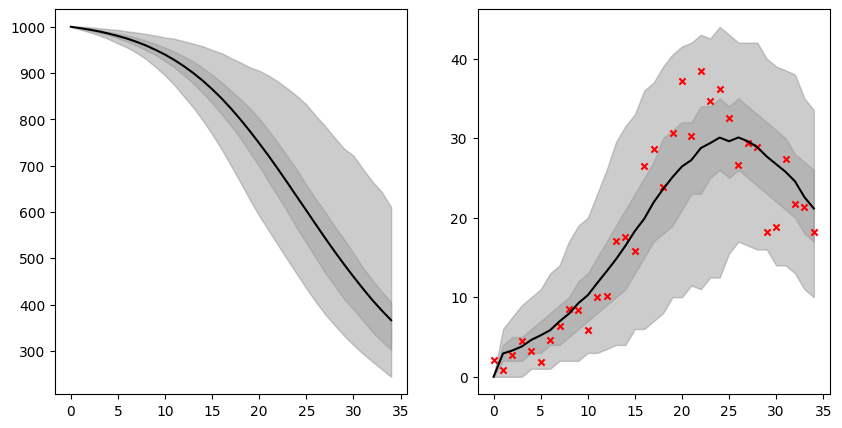

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(S_df.index, S_df['mean'], label='S', color="k")
ax[0].fill_between(S_df.index, S_df['low_95'], S_df['high_95'], alpha=0.4, color="gray")
ax[0].fill_between(S_df.index, S_df['low_50'], S_df['high_50'], alpha=0.3, color="gray")

ax[1].plot(C_df.index, C_df['mean'], label='S', color="k")
ax[1].fill_between(C_df.index, C_df['low_95'], C_df['high_95'], alpha=0.4, color="gray")
ax[1].fill_between(C_df.index, C_df['low_50'], C_df['high_50'], alpha=0.3, color="gray")
ax[1].scatter(S_df.index, obs_use, color="red", marker="x", s=20)


In [8]:
def geometric_cooling(nif, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(nif)
    return alphas**2

def hyperbolic_cooling(nif, cooling_factor=0.9):
    alphas = 1/(1+cooling_factor*np.arange(nif))
    return alphas

def cooling(num_iteration_if, type_cool="geometric", cooling_factor=0.9):
    if type_cool=="geometric":
        return geometric_cooling(num_iteration_if, cooling_factor=cooling_factor)
    elif type_cool=="hyperbolic":
        return hyperbolic_cooling(num_iteration_if, cooling_factor=cooling_factor)


In [ ]:
def poisson_loglikelihood(real_world_observations, model_observations, num_times=100):
    nll =  -np.sum(model_observations,1) + np.sum(real_world_observations*np.log(model_observations+1),1) # Poisson LL
    return - nll

def normal_loglikelihood(real_world_observations, model_observations, error_variance=None, A=0.1, num_times=100):
    if not error_variance:
        error_variance = 1+(0.2*real_world_observations)**2

    nll =  A * np.exp(-0.5 * (real_world_observations-model_observations)**2/error_variance) # Normal LL
    return - nll

def normalize_weights(w):
    """
    Weight normalization.
    w: Particle weights.
    """
    return w / np.sum(w)

def compute_effective_sample_size(w):
    """
    Effective sample size.
    """
    return 1/np.sum(w**2)

def importance_sampling(w, z, y, q):
    """
    Importance sampling:
            Approximate likelihood P(z|θ) using the importance density q(z|y).
            Where y=g(x;θ) is the observation model used after using the state space model f(x;θ).
            Compute the relative weight of each particle respect the previous PF iteration and normalize the weights.
    w: Particle weights.
    z: World observations.
    y: Modelled observations.
    q: Proposal distribution.
    """
    loglik  = q(z , y)

    # Recompute weights and normalize them
    w = w * loglik
    w = normalize_weights(w)

    return w

def naive_weights(m):
    """
    Naive weights.
        Assume all particles have the same weight.
    """
    return np.ones(m)*1/m

def resample_particles(particles, x, w, m, p=None):
    """
    Particle resample.
    """
    if p:
        fixed_particles = np.sort(np.random.choice(np.arange(m), size=int(m*(1-p)), replace=False, p=w))
        particles_index = np.random.choice(np.arange(m), size=m, replace=True, p=w)
        particles_index[fixed_particles] = fixed_particles
    else:
        particles_index = np.sort(np.random.choice(np.arange(m), size=m, replace=True, p=w))

    w         = naive_weights()

    particles = particles[:, particles_index] # Replace particles.
    x_post    = x[:, particles_index]

    return particles, x_post, w


def pf(pprior, x, y, z, q):
    """
    Particle filter.
    """

    # IS(w, z, y, q)
    m = pprior.shape[1]
    w               = importance_sampling(w, z, g(x), q)
    ppost, xpost, w = resample_particles(pprior, x, w, m, p=0.1)

    return ppost, xpost, w



In [ ]:
def iterated_filtering(process_model, observational_model, iterated_filtering_settings):
    """_summary_

    Args:
        process_model (_type_): _description_
        observational_model (_type_): _description_
        iterated_filtering_settings (_type_): _description_
    """